### Contents


1. [Analysis](#ala)

2. [Evaluation Metric](#ev)

3. [Modeling](#mdl)

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import csv
import datetime
from operator import sub
import xgboost as xgb
from sklearn import preprocessing, ensemble

color = sns.color_palette()        

In [2]:
data_path = "../input/santander-product-recommendation/"

train_file = data_path + "train_ver2.csv.zip"

test_file = data_path + "test_ver2.csv.zip"

### Analysis

Dataset Size:

First let us check the number of rows in train and test file

In [3]:
train = pd.read_csv(train_file, usecols=['ncodpers'])

test = pd.read_csv(test_file, usecols=['ncodpers'])

print("Number of rows in train : ", train.shape[0])
print("Number of rows in test : ", test.shape[0])

Number of rows in train :  13647309
Number of rows in test :  929615


No of Customers:

Now let us look at the number of unique customers in train data and test data and also the number of customers common between both

In [4]:
train_unique_customers = set(train.ncodpers.unique())

test_unique_customers = set(test.ncodpers.unique())

print("Number of customers in train : ", len(train_unique_customers))
print("Number of customers in test : ", len(test_unique_customers))
print("Number of common customers : ", len(train_unique_customers.intersection(test_unique_customers)))

Number of customers in train :  956645
Number of customers in test :  929615
Number of common customers :  929615


Let us see the count of occurrences of each of the customers in train set

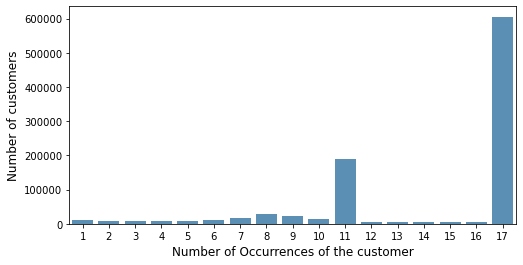

In [5]:
num_occur = train.groupby('ncodpers').agg('size').value_counts()

plt.figure(figsize=(8,4))

sns.barplot(num_occur.index, num_occur.values, alpha=0.8, color=color[0])
plt.xlabel('Number of Occurrences of the customer', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.show()

We have 17 months of data present in our train and we can clearly see that majority of the customers are present for all 17 months. There is also a small spike at '11 month' compared to other months.!

### Target Variables distribution:

There are 24 target variables present in this dataset are as follows:

ind_ahor_fin_ult1 - Saving Account

ind_aval_fin_ult1 - Guarantees

ind_cco_fin_ult1 - Current Accounts

ind_cder_fin_ult1 - Derivada Account

ind_cno_fin_ult1 - Payroll Account

ind_ctju_fin_ult1 - Junior Account

ind_ctma_fin_ult1 - Más particular Account

ind_ctop_fin_ult1 - particular Account

ind_ctpp_fin_ult1 - particular Plus Account

ind_deco_fin_ult1 - Short-term deposits

ind_deme_fin_ult1 - Medium-term deposits

ind_dela_fin_ult1 - Long-term deposits

ind_ecue_fin_ult1 - e-account

ind_fond_fin_ult1 - Funds

ind_hip_fin_ult1 - Mortgage

ind_plan_fin_ult1 - Pensions

ind_pres_fin_ult1 - Loans

ind_reca_fin_ult1 - Taxes

ind_tjcr_fin_ult1 - Credit Card

ind_valo_fin_ult1 - Securities

ind_viv_fin_ult1 - Home Account

ind_nomina_ult1 - Payroll

ind_nom_pens_ult1 - Pensions

ind_recibo_ult1 - Direct Debit

Let us check the number of times the given product has been bought in the train dataset

In [6]:
train = pd.read_csv(data_path+"train_ver2.csv.zip", dtype='float16', 
                    usecols=['ind_ahor_fin_ult1', 'ind_aval_fin_ult1', 
                             'ind_cco_fin_ult1', 'ind_cder_fin_ult1',
                             'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                             'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
                             'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
                             'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                             'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
                             'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
                             'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                             'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
                             'ind_viv_fin_ult1', 'ind_nomina_ult1',
                             'ind_nom_pens_ult1', 'ind_recibo_ult1'])

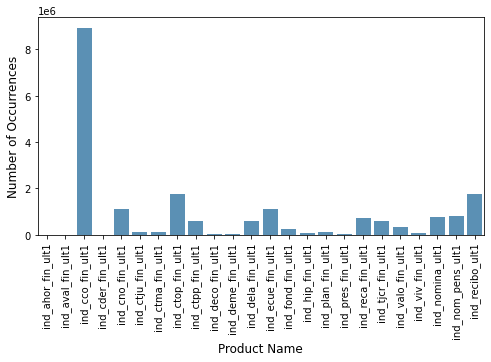

In [7]:
target_counts = train.astype('float64').sum(axis=0)


plt.figure(figsize=(8,4))
sns.barplot(target_counts.index, target_counts.values, alpha=0.8, color=color[0])
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Product "ind_cco_fin_ult1 " is the most bought one and "ind_aval_fin_ult1" is the least bought one.

Exploring Dates:

Let us explore the dates now and see if there are any insights. There are 2 date fields present in the data.

fecha_dato - The date of observation
fecha_alta - The date in which the customer became as the first holder of a contract in the bank

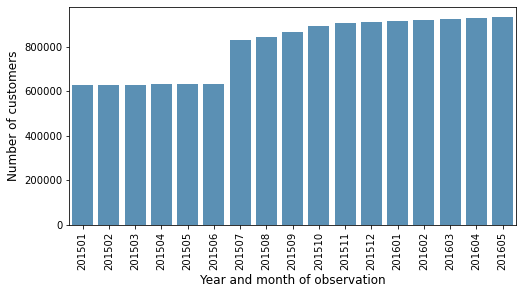

In [8]:
train = pd.read_csv(data_path+"train_ver2.csv.zip", usecols=['fecha_dato', 'fecha_alta'], parse_dates=['fecha_dato', 'fecha_alta'])
train['fecha_dato_yearmonth'] = train['fecha_dato'].apply(lambda x: (100*x.year) + x.month)
yearmonth = train['fecha_dato_yearmonth'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(yearmonth.index, yearmonth.values, alpha=0.8, color=color[0])
plt.xlabel('Year and month of observation', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

For the first six months of the given train data, the number of customers / observations remain almost same and then there is a sudden spike in the number of customers / observations during July 2015.

In [9]:
train.head(3)

,fecha_dato,fecha_alta,fecha_dato_yearmonth
0,2015-01-28,2015-01-12,201501
1,2015-01-28,2012-08-10,201501
2,2015-01-28,2012-08-10,201501


#### when was the first holder of the contracts?

Minimum value of fetcha_alta :  199501.0
Maximum value of fetcha_alta :  201605.0


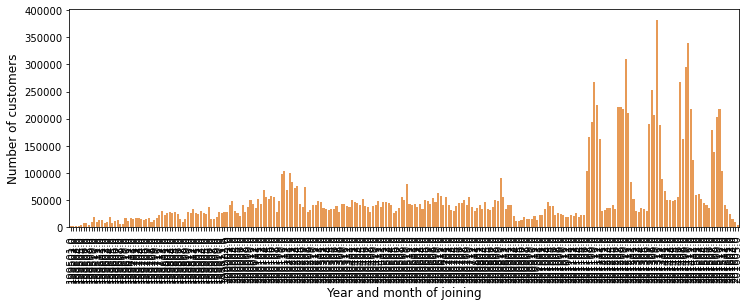

In [10]:
train['fecha_alta_yearmonth'] = train['fecha_alta'].apply(lambda x: (100*x.year) + x.month)

yearmonth = train['fecha_alta_yearmonth'].value_counts()

print("Minimum value of fetcha_alta : ", min(yearmonth.index))
print("Maximum value of fetcha_alta : ", max(yearmonth.index))

plt.figure(figsize=(12,4))
sns.barplot(yearmonth.index, yearmonth.values, alpha=0.8, color=color[1])
plt.xlabel('Year and month of joining', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

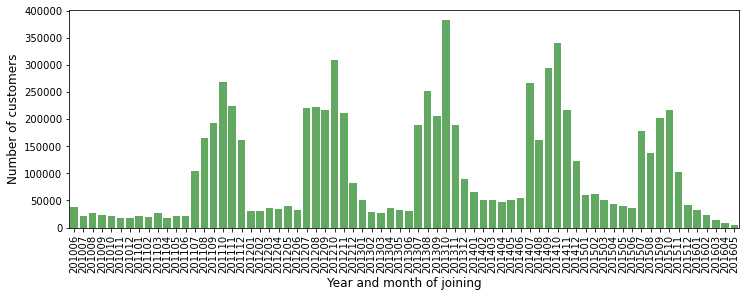

In [11]:
#So the first holder date starts from January 1995. But as we can see, the number is high during the recent years.!
# Also it seems there are some seasonal peaks in the data. Let us have a close look at them.!

year_month = yearmonth.sort_index().reset_index()
year_month = year_month.iloc[185:]
year_month.columns = ['yearmonth', 'number_of_customers']

plt.figure(figsize=(12,4))
sns.barplot(year_month.yearmonth.astype('int'), year_month.number_of_customers, alpha=0.8, color=color[2])
plt.xlabel('Year and month of joining', fontsize=12)
plt.ylabel('Number of customers', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

From 2011, the number of customers becoming the first holder of a contract in the second six months is much higher than the first six months in a calendar year and it is across all years after that. Looks interesting to me from a business standpoint.!

Numerical variables exploration:

Let us explore the 3 numerical variables present in the data.

Age
Antiguedad - customer seniority
Renta
We can check the number of missing values, distribution of the data, distribution of the target variables based on the numerical variables in this notebook.

In [12]:
train = pd.read_csv(train_file, usecols=['age'])
train.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,age
0,35
1,23
2,23
3,22
4,23


In [13]:
print(list(train.age.unique()))

[' 35', ' 23', ' 22', ' 24', ' 65', ' 28', ' 25', ' 26', ' 53', ' 27', ' 32', ' 37', ' 31', ' 39', ' 63', ' 33', ' 55', ' 42', ' 58', ' 38', ' 50', ' 30', ' 45', ' 44', ' 36', ' 29', ' 60', ' 57', ' 67', ' 47', ' NA', ' 34', ' 48', ' 46', ' 54', ' 84', ' 15', ' 12', '  8', '  6', ' 83', ' 40', ' 77', ' 69', ' 52', ' 59', ' 43', ' 10', '  9', ' 49', ' 41', ' 51', ' 78', ' 16', ' 11', ' 73', ' 62', ' 66', ' 17', ' 68', ' 82', ' 95', ' 96', ' 56', ' 61', ' 79', ' 72', ' 14', ' 19', ' 13', ' 86', ' 64', ' 20', ' 89', ' 71', '  7', ' 70', ' 74', ' 21', ' 18', ' 75', '  4', ' 80', ' 81', '  5', ' 76', ' 92', ' 93', ' 85', ' 91', ' 87', ' 90', ' 94', ' 99', ' 98', ' 88', ' 97', '100', '101', '106', '103', '  3', '  2', '102', '104', '111', '107', '109', '105', '112', '115', '110', '116', '108', '113', 37, 81, 43, 30, 45, 41, 67, 59, 46, 36, 47, 69, 39, 44, 40, 38, 34, 42, 31, 35, 48, 60, 54, 51, 33, 62, 50, 11, 57, 55, 85, 80, 70, 32, 52, 94, 61, 13, 29, 49, 76, 28, 63, 10, 88, 68, 64, 58, 56

In [14]:
#There are quite a few different formats for age (number, string with leading spaces, string).
#Also if we see, there is a ' NA' value present in this field. So let us first take care of that by changing it to np.nan.

train['age'] = train['age'].replace(to_replace=[' NA'], value=np.nan)

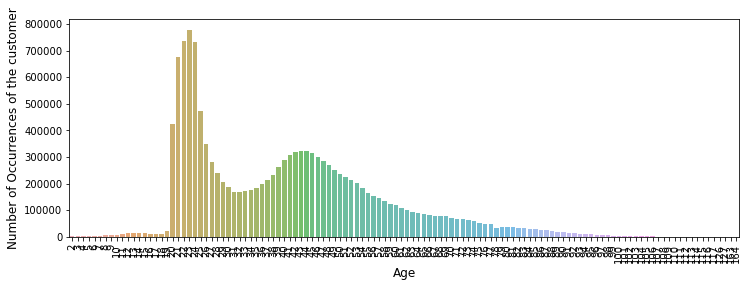

In [15]:
# We can now convert the field to dtype 'float' and then get the counts

train['age'] = train['age'].astype('float64')

age_series = train.age.value_counts()
plt.figure(figsize=(12,4))
sns.barplot(age_series.index.astype('int'), age_series.values, alpha=0.8)
plt.ylabel('Number of Occurrences of the customer', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### We could see that there is a very long tail at both the ends. So we can have min and max cap at some points respectively (I would use 20 and 86 from the graph).

#### Do train and test come from the same distribution?

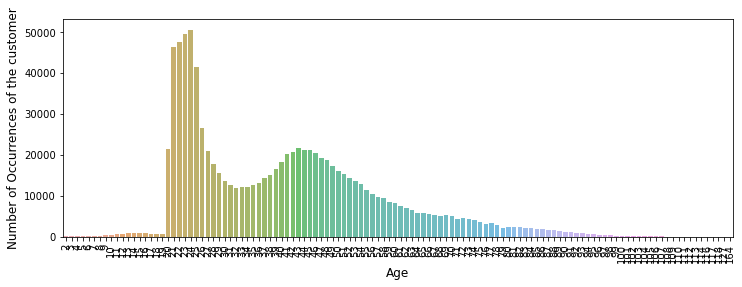

In [16]:
#We have 27734 missing values and the mean age is 40. We could probably do a mean imputation here.
# We could look at test set age distribution to confirm both train and test have same distribution.

test = pd.read_csv(test_file, usecols=['age'])
test['age'] = test['age'].replace(to_replace=[' NA'], value=np.nan)
test['age'] = test['age'].astype('float64')

age_series = test.age.value_counts()
plt.figure(figsize=(12,4))
sns.barplot(age_series.index.astype('int'), age_series.values, alpha=0.8)
plt.ylabel('Number of Occurrences of the customer', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

#### Good to see that the distribution is similar between train and test.!

#### ANTIGUEDAD:

Customer seniority in months.

In [17]:
train = pd.read_csv(train_file, usecols=['antiguedad'])
 

print(list(train.antiguedad.unique()))

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['      6', '     35', '     34', '     NA', '     33', '     31', '     21', '     16', '     27', '      9', '     22', '     13', '     29', '      8', '     11', '     10', '     28', '     24', '      7', '     25', '     14', '     26', '     12', '     23', '      1', '     18', '      4', '      3', '     17', '     32', '     30', '     20', '     15', '     19', '    157', '     36', '      5', '     40', '     38', '     37', '     39', '      0', '      2', '     47', '     44', '     42', '     46', '     45', '     43', '     41', '     57', '     48', '     52', '     49', '     50', '     56', '     58', '     51', '     55', '     54', '     53', '     59', '     62', '     61', '     60', '     63', '    139', '    165', '    118', '    164', '    142', '     94', '    159', '    143', '    105', '    151', '    162', '    137', '    150', '    128', '    122', '    156', '    119', '    160', '     79', '     95', '    132', '    161', '     98', '    127', '     72'

Here again we could see that there is a ' NA' value present in this field similar to age. Also we could see that there is a special value '-999999' present in the data. May be this special value also represent missing value?!

We shall first convert the NA value to np.nan value

In [18]:
train['antiguedad'] = train['antiguedad'].replace(to_replace=['     NA'], value=np.nan)

train.antiguedad.isnull().sum()

27734

In [19]:
# So here again we have 27734 missing values.
# We can convert the field to dtype 'float' and then check the count of special value -999999.

train['antiguedad'] = train['antiguedad'].astype('float64')

(train['antiguedad'] == -999999.0).sum()

38

We have 38 special values. If we use a tree based model, we could probably leave it as such or if we use a linear model, we need to map it to mean or some value in the range of 0 to 256.

Now we can see the distribution plot of this variable.

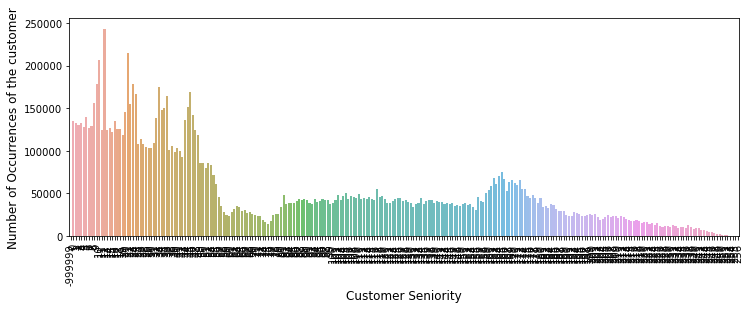

In [20]:
col_series = train.antiguedad.value_counts()
plt.figure(figsize=(12,4))
sns.barplot(col_series.index.astype('int'), col_series.values, alpha=0.8)
plt.ylabel('Number of Occurrences of the customer', fontsize=12)
plt.xlabel('Customer Seniority', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

Does the test set follow the same?

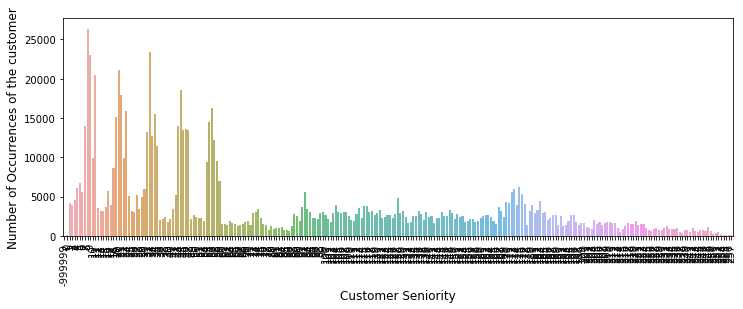

In [21]:
test = pd.read_csv(test_file, usecols=['antiguedad'])
test['antiguedad'] = test['antiguedad'].replace(to_replace=[' NA'], value=np.nan)
test['antiguedad'] = test['antiguedad'].astype('float64')

col_series = test.antiguedad.value_counts()
plt.figure(figsize=(12,4))
sns.barplot(col_series.index.astype('int'), col_series.values, alpha=0.8)
plt.ylabel('Number of Occurrences of the customer', fontsize=12)
plt.xlabel('Customer Seniority', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

RENTA:

Gross income of the household.



In [22]:
train = pd.read_csv(train_file, usecols=['renta'])
train.head()

,renta
0,87218.10
1,35548.74
2,122179.11
3,119775.54
4,NaN


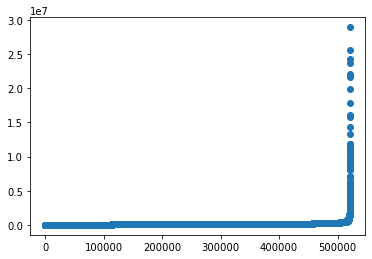

In [23]:
unique_values = np.sort(train.renta.unique())

plt.scatter(range(len(unique_values)), unique_values)

plt.show()

It seems the distribution of rent is highly skewed. There are few very high valued customers present in the data.

Let us get the mean and median value for this field.

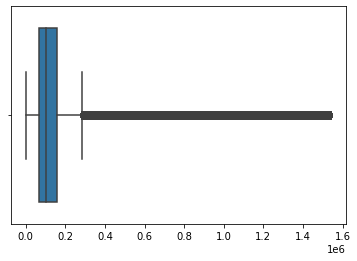

In [24]:
rent_max_cap = train.renta.quantile(0.999)
train['renta'][train['renta']>rent_max_cap] = 101850.0 # assigining median value 
sns.boxplot(train.renta.values)
plt.show()

From the box plot, we can see that most of the rent values fall between 0 and 300,000.

Now we can see the distribution of rent in test data as well.

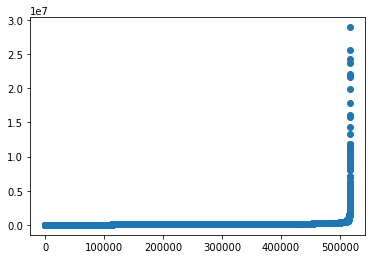

In [25]:
test = pd.read_csv(test_file, usecols=['renta'])
test['renta'] = test['renta'].replace(to_replace=['         NA'], value=np.nan).astype('float') # note that there is NA value in test
unique_values = np.sort(test.renta.unique())
plt.scatter(range(len(unique_values)), unique_values)
plt.show()

Numerical variables Vs Target variables:

Now let us see how the targets are distributed based on the numerical variables present in the data. Let us subset the first 100K rows for the same.

In [26]:
train = pd.read_csv(data_path+"train_ver2.csv.zip", nrows=100000)

target_cols = ['ind_cco_fin_ult1', 'ind_cder_fin_ult1',
                             'ind_cno_fin_ult1', 'ind_ctju_fin_ult1',
                             'ind_ctma_fin_ult1', 'ind_ctop_fin_ult1',
                             'ind_ctpp_fin_ult1', 'ind_deco_fin_ult1',
                             'ind_deme_fin_ult1', 'ind_dela_fin_ult1',
                             'ind_ecue_fin_ult1', 'ind_fond_fin_ult1',
                             'ind_hip_fin_ult1', 'ind_plan_fin_ult1',
                             'ind_pres_fin_ult1', 'ind_reca_fin_ult1',
                             'ind_tjcr_fin_ult1', 'ind_valo_fin_ult1',
                             'ind_viv_fin_ult1', 'ind_nomina_ult1',
                             'ind_nom_pens_ult1', 'ind_recibo_ult1']

train[target_cols] = (train[target_cols].fillna(0))
train["age"] = train['age'].map(str.strip).replace(['NA'], value=0).astype('float')
train["antiguedad"] = train["antiguedad"].map(str.strip)
train["antiguedad"] = train['antiguedad'].replace(['NA'], value=0).astype('float')
train["antiguedad"].iloc[train["antiguedad"]>65] = 65 # there is one very high skewing the graph
train["renta"].iloc[train["renta"]>1e6] = 1e6 # capping the higher values for better visualisation
train.fillna(-1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


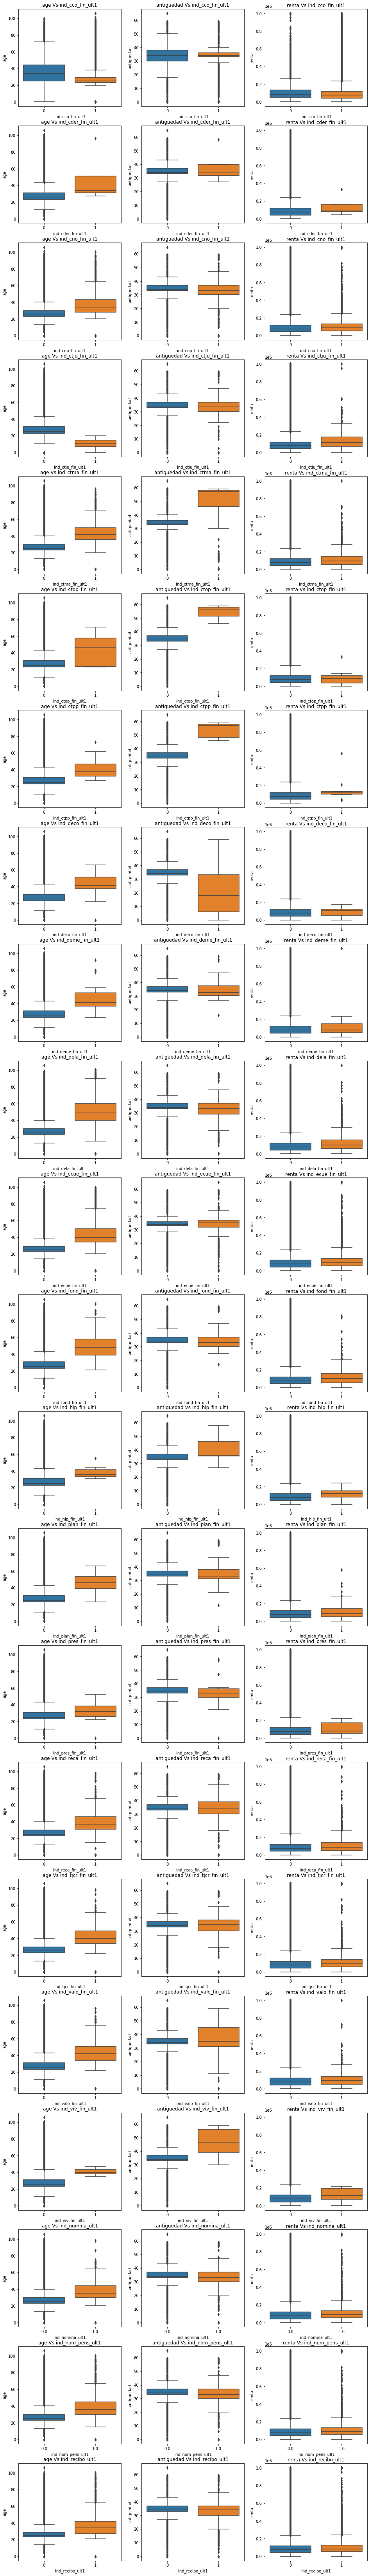

In [27]:
fig = plt.figure(figsize=(16, 120))
numeric_cols = ['age', 'antiguedad', 'renta']
#for ind1, numeric_col in enumerate(numeric_cols):
plot_count = 0
for ind, target_col in enumerate(target_cols):
    for numeric_col in numeric_cols:
        plot_count += 1
        plt.subplot(22, 3, plot_count)
        sns.boxplot(x=target_col, y=numeric_col, data=train)
        plt.title(numeric_col+" Vs "+target_col)
plt.show()

Seems all these numerical variables have some predictive power since they show some different behavior between 0's and 1's.

Exploring categorical fields:

Now let us look at the distribution of categorical fields present in the data by using the first 1 million rows.

Number of unique values in  ind_empleado  :  6


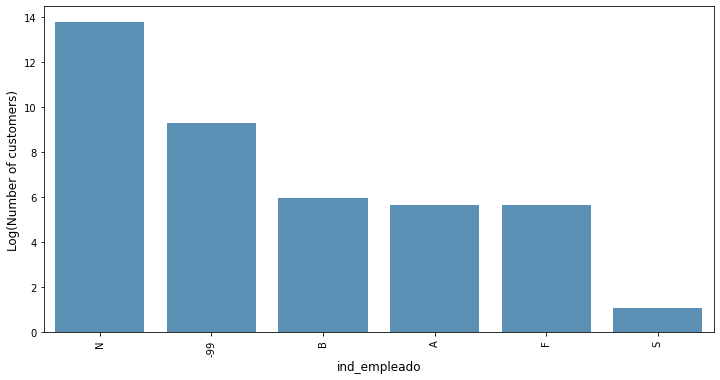


Number of unique values in  pais_residencia  :  114


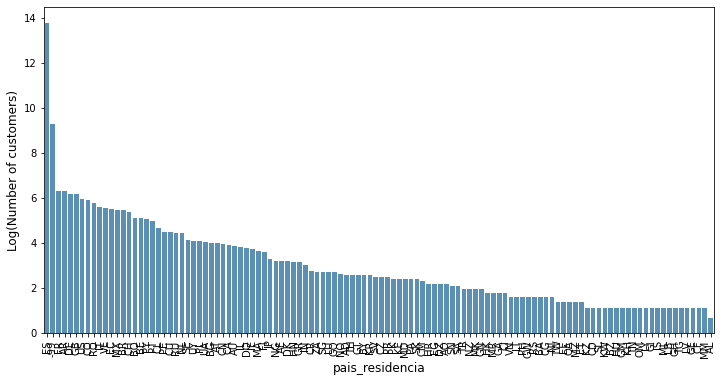


Number of unique values in  sexo  :  3


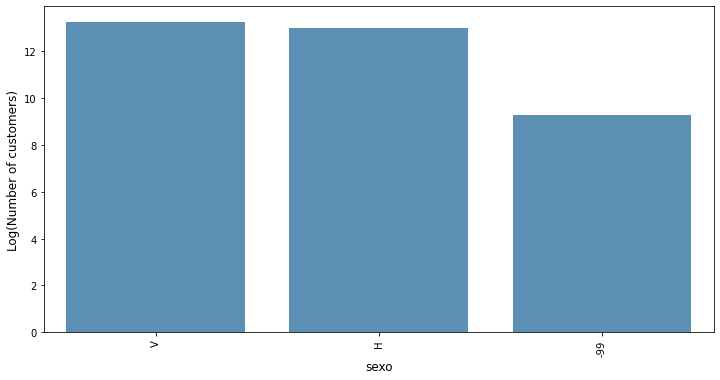


Number of unique values in  ind_nuevo  :  3


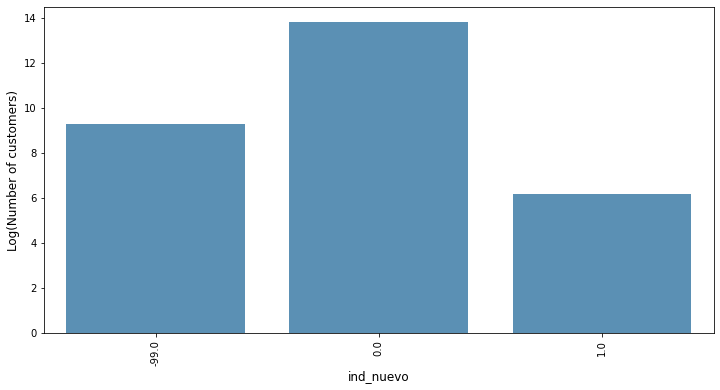


Number of unique values in  indrel  :  3


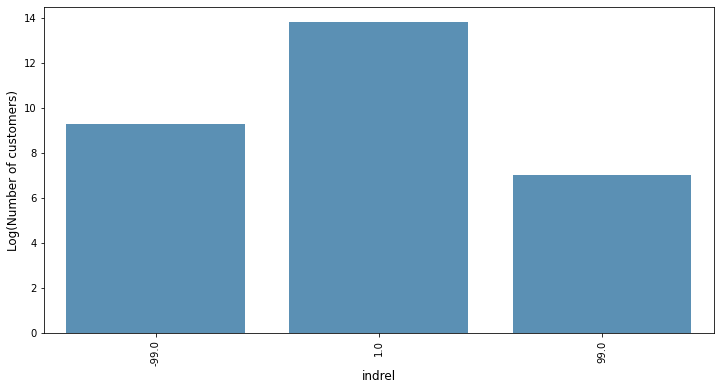


Number of unique values in  ult_fec_cli_1t  :  23


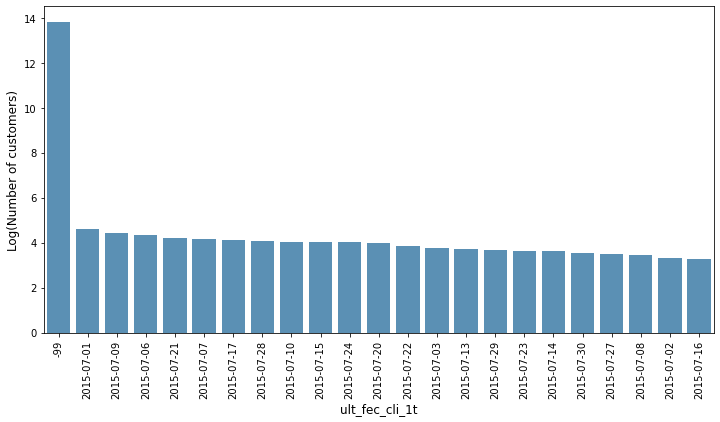


Number of unique values in  indrel_1mes  :  4


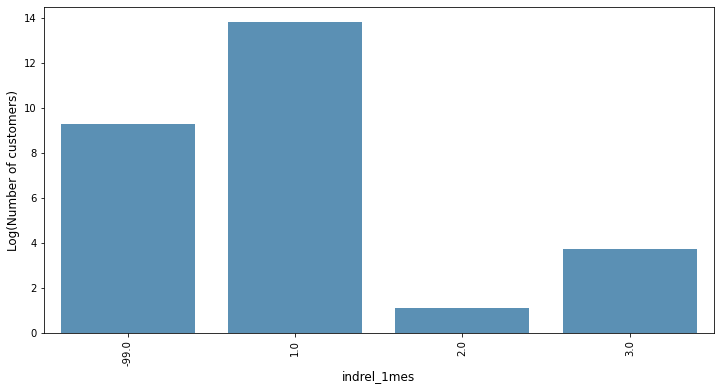


Number of unique values in  tiprel_1mes  :  4


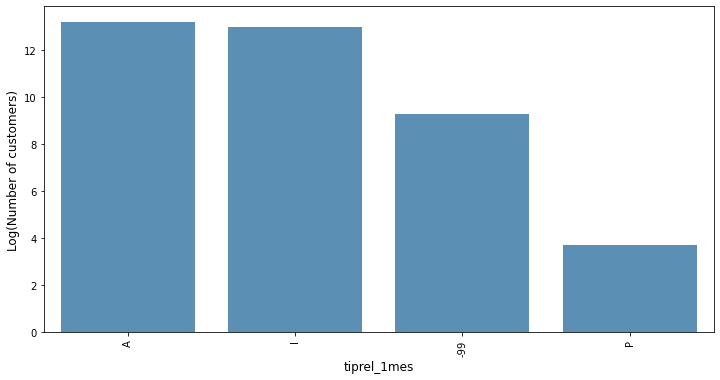


Number of unique values in  indresi  :  3


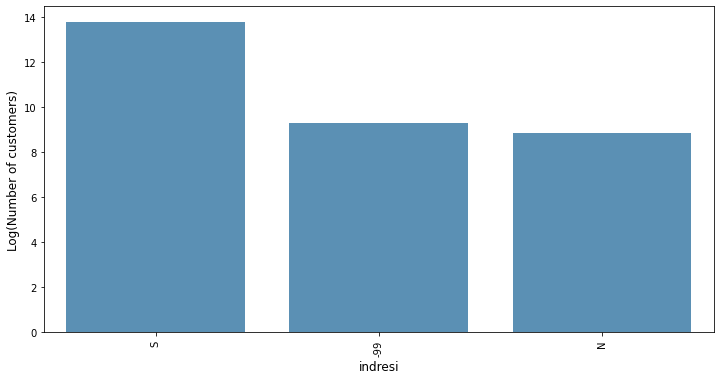


Number of unique values in  indext  :  3


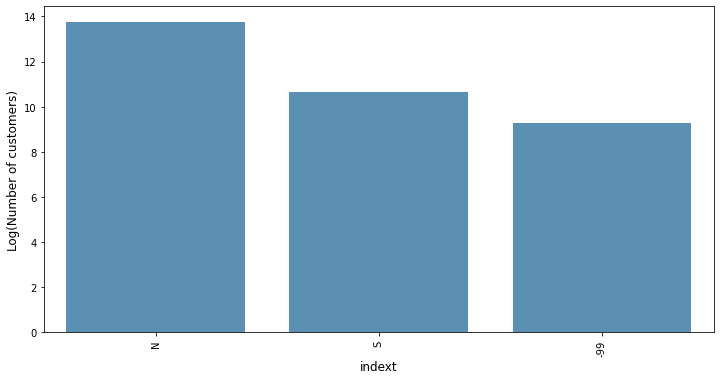

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of unique values in  conyuemp  :  3


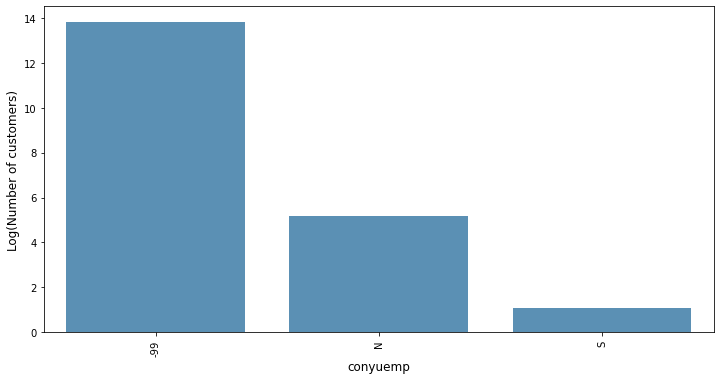


Number of unique values in  canal_entrada  :  157


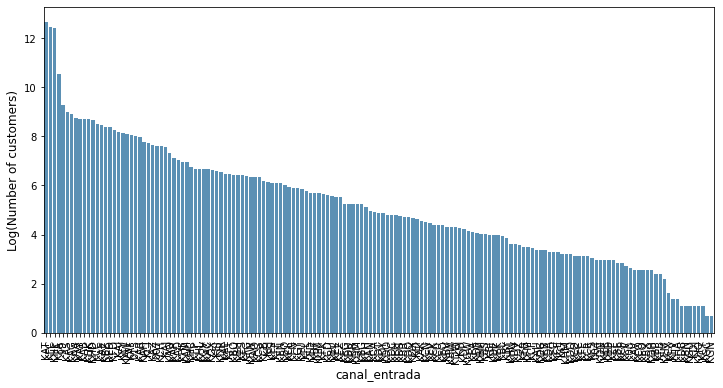


Number of unique values in  indfall  :  3


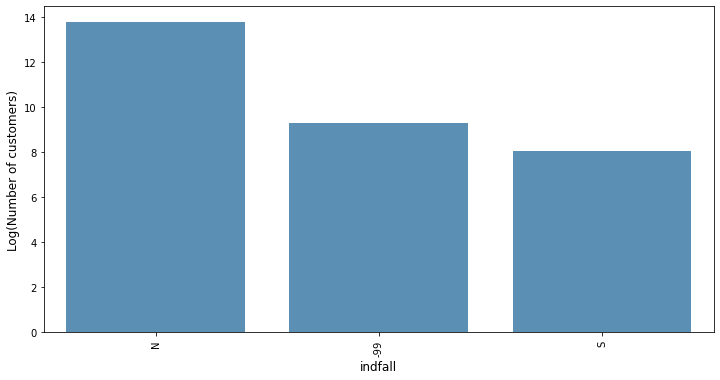


Number of unique values in  tipodom  :  2


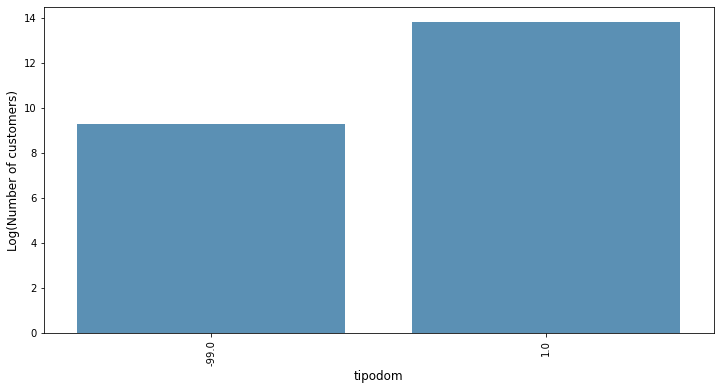


Number of unique values in  cod_prov  :  53


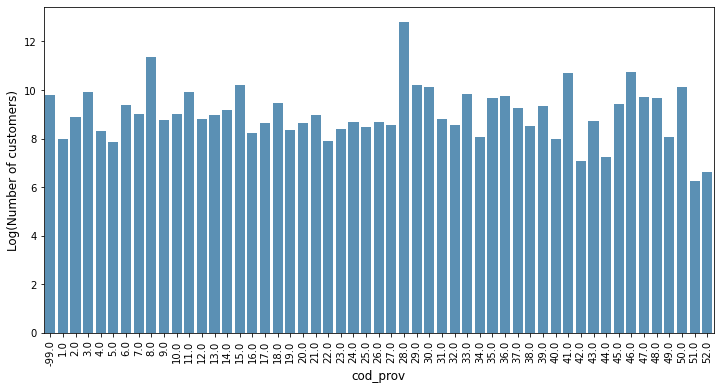


Number of unique values in  nomprov  :  53


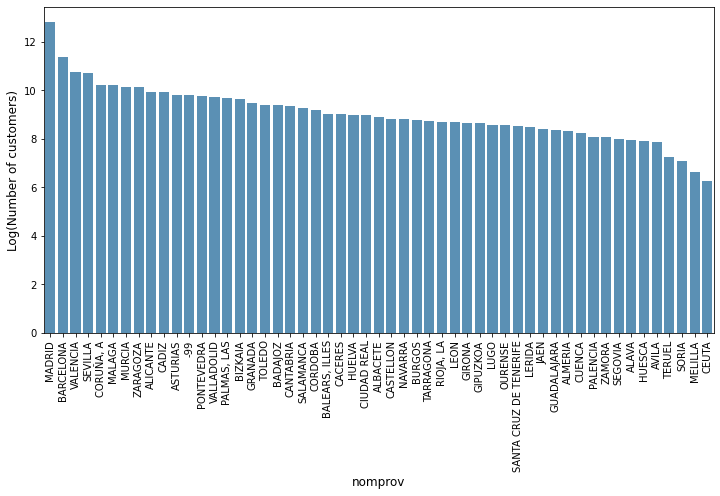


Number of unique values in  ind_actividad_cliente  :  3


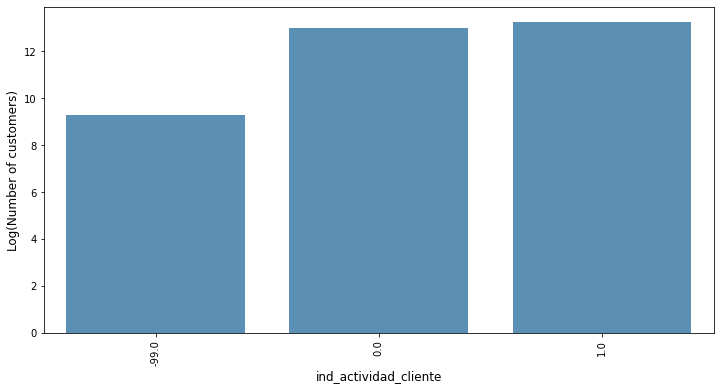


Number of unique values in  segmento  :  4


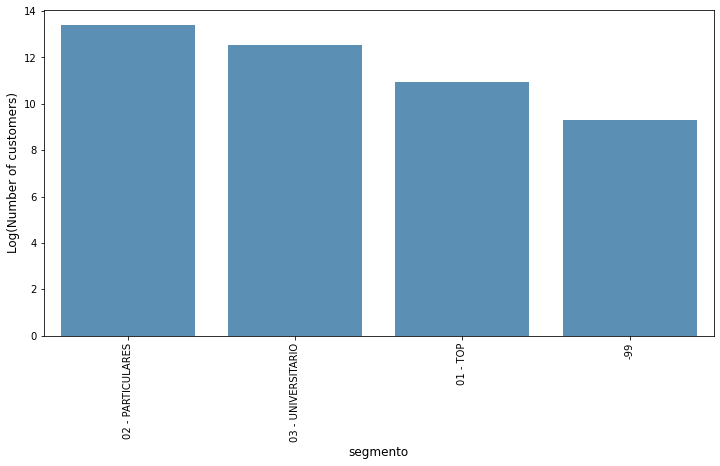

In [28]:
cols = ["ind_empleado","pais_residencia","sexo","ind_nuevo","indrel","ult_fec_cli_1t","indrel_1mes","tiprel_1mes","indresi","indext","conyuemp","canal_entrada","indfall","tipodom","cod_prov","nomprov","ind_actividad_cliente","segmento"]

for col in cols:
    train = pd.read_csv(data_path+"train_ver2.csv.zip", usecols = ["ncodpers", col], nrows=1000000)
    train = train.fillna(-99)
    len_unique = len(train[col].unique())
    print("Number of unique values in ",col," : ",len_unique)
    if len_unique < 200:
        agg_df = train[col].value_counts()
        plt.figure(figsize=(12,6))
        sns.barplot(agg_df.index, np.log1p(agg_df.values), alpha=0.8, color=color[0])
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Log(Number of customers)', fontsize=12)
        plt.xticks(rotation='vertical')
        plt.show()
    print()

### Modeling 


#### For the modeling, let us consider data only from May 2015 to May 2016 and predict for June 2016.

#### Saving the modified train file and test files to work as Python modules.

#### Enumerating the categorical columns

In [29]:
mapping_dict = {
    
'ind_empleado'  : {-99:0, 'N':1, 'B':2, 'F':3, 'A':4, 'S':5},
'sexo'          : {'V':0, 'H':1, -99:2},
'ind_nuevo'     : {'0':0, '1':1, -99:2},
'indrel'        : {'1':0, '99':1, -99:2},
'indrel_1mes'   : {-99:0, '1.0':1, '1':1, '2.0':2, '2':2, '3.0':3, '3':3, '4.0':4, '4':4, 'P':5},
'tiprel_1mes'   : {-99:0, 'I':1, 'A':2, 'P':3, 'R':4, 'N':5},
'indresi'       : {-99:0, 'S':1, 'N':2},
'indext'        : {-99:0, 'S':1, 'N':2},
'conyuemp'      : {-99:0, 'S':1, 'N':2},
'indfall'       : {-99:0, 'S':1, 'N':2},
'tipodom'       : {-99:0, '1':1},
'ind_actividad_cliente' : {'0':0, '1':1, -99:2},
'segmento'      : {'02 - PARTICULARES':0, '03 - UNIVERSITARIO':1, '01 - TOP':2, -99:2},
'pais_residencia' : {'LV': 102, 'BE': 12, 'BG': 50, 'BA': 61, 'BM': 117, 'BO': 62, 'JP': 82, 'JM': 116, 'BR': 17, 'BY': 64, 'BZ': 113, 'RU': 43, 'RS': 89, 'RO': 41, 'GW': 99, 'GT': 44, 'GR': 39, 'GQ': 73, 'GE': 78, 'GB': 9, 'GA': 45, 'GN': 98, 'GM': 110, 'GI': 96, 'GH': 88, 'OM': 100, 'HR': 67, 'HU': 106, 'HK': 34, 'HN': 22, 'AD': 35, 'PR': 40, 'PT': 26, 'PY': 51, 'PA': 60, 'PE': 20, 'PK': 84, 'PH': 91, 'PL': 30, 'EE': 52, 'EG': 74, 'ZA': 75, 'EC': 19, 'AL': 25, 'VN': 90, 'ET': 54, 'ZW': 114, 'ES': 0, 'MD': 68, 'UY': 77, 'MM': 94, 'ML': 104, 'US': 15, 'MT': 118, 'MR': 48, 'UA': 49, 'MX': 16, 'IL': 42, 'FR': 8, 'MA': 38, 'FI': 23, 'NI': 33, 'NL': 7, 'NO': 46, 'NG': 83, 'NZ': 93, 'CI': 57, 'CH': 3, 'CO': 21, 'CN': 28, 'CM': 55, 'CL': 4, 'CA': 2, 'CG': 101, 'CF': 109, 'CD': 112, 'CZ': 36, 'CR': 32, 'CU': 72, 'KE': 65, 'KH': 95, 'SV': 53, 'SK': 69, 'KR': 87, 'KW': 92, 'SN': 47, 'SL': 97, 'KZ': 111, 'SA': 56, 'SG': 66, 'SE': 24, 'DO': 11, 'DJ': 115, 'DK': 76, 'DE': 10, 'DZ': 80, 'MK': 105, -99: 1, 'LB': 81, 'TW': 29, 'TR': 70, 'TN': 85, 'LT': 103, 'LU': 59, 'TH': 79, 'TG': 86, 'LY': 108, 'AE': 37, 'VE': 14, 'IS': 107, 'IT': 18, 'AO': 71, 'AR': 13, 'AU': 63, 'AT': 6, 'IN': 31, 'IE': 5, 'QA': 58, 'MZ': 27},
'canal_entrada' : {'013': 49, 'KHP': 160, 'KHQ': 157, 'KHR': 161, 'KHS': 162, 'KHK': 10, 'KHL': 0, 'KHM': 12, 'KHN': 21, 'KHO': 13, 'KHA': 22, 'KHC': 9, 'KHD': 2, 'KHE': 1, 'KHF': 19, '025': 159, 'KAC': 57, 'KAB': 28, 'KAA': 39, 'KAG': 26, 'KAF': 23, 'KAE': 30, 'KAD': 16, 'KAK': 51, 'KAJ': 41, 'KAI': 35, 'KAH': 31, 'KAO': 94, 'KAN': 110, 'KAM': 107, 'KAL': 74, 'KAS': 70, 'KAR': 32, 'KAQ': 37, 'KAP': 46, 'KAW': 76, 'KAV': 139, 'KAU': 142, 'KAT': 5, 'KAZ': 7, 'KAY': 54, 'KBJ': 133, 'KBH': 90, 'KBN': 122, 'KBO': 64, 'KBL': 88, 'KBM': 135, 'KBB': 131, 'KBF': 102, 'KBG': 17, 'KBD': 109, 'KBE': 119, 'KBZ': 67, 'KBX': 116, 'KBY': 111, 'KBR': 101, 'KBS': 118, 'KBP': 121, 'KBQ': 62, 'KBV': 100, 'KBW': 114, 'KBU': 55, 'KCE': 86, 'KCD': 85, 'KCG': 59, 'KCF': 105, 'KCA': 73, 'KCC': 29, 'KCB': 78, 'KCM': 82, 'KCL': 53, 'KCO': 104, 'KCN': 81, 'KCI': 65, 'KCH': 84, 'KCK': 52, 'KCJ': 156, 'KCU': 115, 'KCT': 112, 'KCV': 106, 'KCQ': 154, 'KCP': 129, 'KCS': 77, 'KCR': 153, 'KCX': 120, 'RED': 8, 'KDL': 158, 'KDM': 130, 'KDN': 151, 'KDO': 60, 'KDH': 14, 'KDI': 150, 'KDD': 113, 'KDE': 47, 'KDF': 127, 'KDG': 126, 'KDA': 63, 'KDB': 117, 'KDC': 75, 'KDX': 69, 'KDY': 61, 'KDZ': 99, 'KDT': 58, 'KDU': 79, 'KDV': 91, 'KDW': 132, 'KDP': 103, 'KDQ': 80, 'KDR': 56, 'KDS': 124, 'K00': 50, 'KEO': 96, 'KEN': 137, 'KEM': 155, 'KEL': 125, 'KEK': 145, 'KEJ': 95, 'KEI': 97, 'KEH': 15, 'KEG': 136, 'KEF': 128, 'KEE': 152, 'KED': 143, 'KEC': 66, 'KEB': 123, 'KEA': 89, 'KEZ': 108, 'KEY': 93, 'KEW': 98, 'KEV': 87, 'KEU': 72, 'KES': 68, 'KEQ': 138, -99: 6, 'KFV': 48, 'KFT': 92, 'KFU': 36, 'KFR': 144, 'KFS': 38, 'KFP': 40, 'KFF': 45, 'KFG': 27, 'KFD': 25, 'KFE': 148, 'KFB': 146, 'KFC': 4, 'KFA': 3, 'KFN': 42, 'KFL': 34, 'KFM': 141, 'KFJ': 33, 'KFK': 20, 'KFH': 140, 'KFI': 134, '007': 71, '004': 83, 'KGU': 149, 'KGW': 147, 'KGV': 43, 'KGY': 44, 'KGX': 24, 'KGC': 18, 'KGN': 11}
    
}

cat_cols = list(mapping_dict.keys())

target_cols = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']

target_cols = target_cols[2:]

### Helper Functions ( Feature generation )

In [30]:
def getTarget(row):
	tlist = []
	for col in target_cols:
		if row[col].strip() in ['', 'NA']:
			target = 0
		else:
			target = int(float(row[col]))
		tlist.append(target)
	return tlist

def getIndex(row, col):
	val = row[col].strip()
	if val not in ['','NA']:
		ind = mapping_dict[col][val]
	else:
		ind = mapping_dict[col][-99]
	return ind

In [31]:
def getAge(row):
	mean_age = 40.
	min_age = 20.
	max_age = 90.
	range_age = max_age - min_age
	age = row['age'].strip()
	if age == 'NA' or age == '':
		age = mean_age
	else:
		age = float(age)
		if age < min_age:
			age = min_age
		elif age > max_age:
			age = max_age
	return round( (age - min_age) / range_age, 4)

def getCustSeniority(row):
	min_value = 0.
	max_value = 256.
	range_value = max_value - min_value
	missing_value = 0.
	cust_seniority = row['antiguedad'].strip()
	if cust_seniority == 'NA' or cust_seniority == '':
		cust_seniority = missing_value
	else:
		cust_seniority = float(cust_seniority)
		if cust_seniority < min_value:
			cust_seniority = min_value
		elif cust_seniority > max_value:
			cust_seniority = max_value
	return round((cust_seniority-min_value) / range_value, 4)

def getRent(row):
	min_value = 0.
	max_value = 1500000.
	range_value = max_value - min_value
	missing_value = 101850.
	rent = row['renta'].strip()
	if rent == 'NA' or rent == '':
		rent = missing_value
	else:
		rent = float(rent)
		if rent < min_value:
			rent = min_value
		elif rent > max_value:
			rent = max_value
	return round((rent-min_value) / range_value, 6)

def processData(in_file_name, cust_dict):
	x_vars_list = []
	y_vars_list = []
	for row in csv.DictReader(in_file_name):
		# use only the four months as specified by breakfastpirate #
		if row['fecha_dato'] not in ['2015-05-28', '2015-06-28', '2016-05-28', '2016-06-28']:
			continue

		cust_id = int(row['ncodpers'])
		if row['fecha_dato'] in ['2015-05-28', '2016-05-28']:	
			target_list = getTarget(row)
			cust_dict[cust_id] =  target_list[:]
			continue

		x_vars = []
		for col in cat_cols:
			x_vars.append( getIndex(row, col) )
		x_vars.append( getAge(row) )
		x_vars.append( getCustSeniority(row) )
		x_vars.append( getRent(row) )

		if row['fecha_dato'] == '2016-06-28':
			prev_target_list = cust_dict.get(cust_id, [0]*22)
			x_vars_list.append(x_vars + prev_target_list)
		elif row['fecha_dato'] == '2015-06-28':
			prev_target_list = cust_dict.get(cust_id, [0]*22)
			target_list = getTarget(row)
			new_products = [max(x1 - x2,0) for (x1, x2) in zip(target_list, prev_target_list)]
			if sum(new_products) > 0:
				for ind, prod in enumerate(new_products):
					if prod>0:
						assert len(prev_target_list) == 22
						x_vars_list.append(x_vars+prev_target_list)
						y_vars_list.append(ind)

	return x_vars_list, y_vars_list, cust_dict

### Model

In [32]:
def runXGB(train_X, train_y, seed_val=0):
	param = {}
	param['objective'] = 'multi:softprob'
	param['eta'] = 0.05
	param['max_depth'] = 8
	param['silent'] = 1
	param['num_class'] = 22
	param['eval_metric'] = "mlogloss"
	param['min_child_weight'] = 1
	param['subsample'] = 0.7
	param['colsample_bytree'] = 0.7
	param['seed'] = seed_val
	num_rounds = 50

	plst = list(param.items())
	xgtrain = xgb.DMatrix(train_X, label=train_y)
	model = xgb.train(plst, xgtrain, num_rounds)	
	return model

In [33]:
from subprocess import check_output
print(check_output(["ls", "../input/santander-product-recommendation"]).decode("utf8"))

sample_submission.csv.zip
test_ver2.csv.zip
train_ver2.csv.zip



In [34]:
import zipfile
train = "train_ver2.csv"
with zipfile.ZipFile("../input/santander-product-recommendation/"+train+".zip","r") as z:
    z.extractall(".")

In [35]:
import zipfile
test = "test_ver2.csv"
with zipfile.ZipFile("../input/santander-product-recommendation/"+test+".zip","r") as z:
    z.extractall(".")

In [36]:
from subprocess import check_output
print(check_output(["ls", train]).decode("utf8"))
print(check_output(["ls", test]).decode("utf8"))

train_ver2.csv

test_ver2.csv



In [ ]:
!ls

In [ ]:
import pandas as pd

traint = pd.read_csv("train_ver2.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,8,11,15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
train_main = traint[traint['fecha_dato'] >= '2015-04-30']

In [ ]:
train_main.to_csv('train_main.csv', index=False)

In [ ]:
!ls

In [ ]:
start_time = datetime.datetime.now()
data_path = "../input/santander-product-recommendation/"

train_file =  open("train_ver2.csv")

#train_file =  open(data_path + "train_ver2.csv.zip")
x_vars_list, y_vars_list, cust_dict = processData(train_file, {})

train_X = np.array(x_vars_list)
train_y = np.array(y_vars_list)
print(np.unique(train_y))

del x_vars_list, y_vars_list
train_file.close()

print(train_X.shape, train_y.shape)
print(datetime.datetime.now()-start_time)

test_file = open("test_ver2.csv")
x_vars_list, y_vars_list, cust_dict = processData(test_file, cust_dict)
test_X = np.array(x_vars_list)
del x_vars_list

test_file.close()
print(test_X.shape)
print(datetime.datetime.now()-start_time)

print("Building model..")
model = runXGB(train_X, train_y, seed_val=0)
del train_X, train_y

print("Predicting..")
xgtest = xgb.DMatrix(test_X)
preds = model.predict(xgtest)

del test_X, xgtest
print(datetime.datetime.now()-start_time)
print("Getting the top products..")

target_cols = np.array(target_cols)
preds = np.argsort(preds, axis=1)
preds = np.fliplr(preds)[:,:7]

In [ ]:
test_id = np.array(pd.read_csv("test_ver2.csv", usecols=['ncodpers'])['ncodpers'])
final_preds = [" ".join(list(target_cols[pred])) for pred in preds]
out_df = pd.DataFrame({'ncodpers':test_id, 'added_products':final_preds})

out_df.to_csv('sub_xgb_new.csv', index=False)

print(datetime.datetime.now()-start_time)

In [ ]:
out_df.head(10)

In [ ]:
### Pickling the model to deploy

import pickle
file_name = "xgb.pkl"
pickle.dump(model, open(file_name, "wb"))
#load
xgb_model_loaded = pickle.load(open(file_name, "rb"))